<a href="https://colab.research.google.com/github/luchosic/SOA/blob/main/HPC/Cuaderno_2_grupo3_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introducción

En este ejercicio vamos a demostrar cómo varia el tiempo de ejecución de un programa que multiplica matrices, utilizando CPU vs GPU. Este es un típico problema donde el uso de la GPU ayuda a disminuir el tiempo de procesamiento cuando la complejidad del algoritmo aumenta.</br></br>

La multiplicación de matrices se realiza de la siguiente forma:

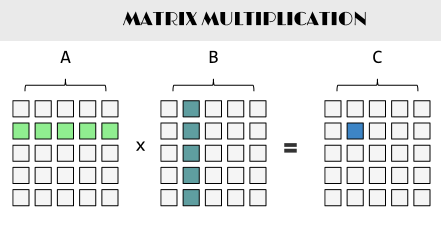


# 2 Armado del ambiente



In [6]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ### Especifique el inicio del rango de valores numéricos que tendrá la matriz
inicio_rango =   1#@param {type: "number"}
#@markdown ### Especifique el fin del rango de valores numéricos que tendrá la matriz
fin_rango =   50#@param {type: "number"}

#@markdown ### Especifique el tamaño de la matriz
tamano_matriz =   500#@param {type: "number"}

# 3 Desarrollo CPU

In [7]:
%matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
import random

#inicializo las matrices cuadradas con valores random dentro del rango ingresado por el usuario
matriz_a = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_b = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_resultado = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango


# Itero por filas de X
for i in range(len(matriz_a)):
   # Itero por columnas de Y
   for j in range(len(matriz_b[0])):
       # itero por filas de Y
       for k in range(len(matriz_b)):
           matriz_resultado[i][j] += matriz_a[i][k] * matriz_b[k][j]

print( "\n\nMatriz Resultado:" )
for r in matriz_resultado:
   print(r)

tiempo_total_cpu = datetime.now() - tiempo_total_cpu  

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 315867.82669061 326462.98141088 321901.87242799 324645.01937287
 306333.88691123 303198.1857681  324561.28635221 315856.39864775
 317673.14436512 316542.91437578 307642.74892603 324144.4807135
 320783.24926741 306366.93230512 322895.42389538 305028.4028362
 340052.73673824 305572.17507416 310996.10222312 295319.87594229
 312671.16299016 336197.69302056 322457.2238444  308876.50459428
 312986.87734798 317274.30496304 308209.90459115 303689.60321437
 334838.39422658 318824.47333179 327777.32711133 318409.78176729
 333880.23570847 322071.85503415 302087.56469838 307201.34765854
 321364.61606615 322544.84824757 331412.36649296 323229.41921627
 323013.48580587 321320.55993124 320149.74847304 343586.47024412
 325428.76498796 331085.81747053 338960.3578707  320681.72925938
 319048.68795978 300661.50874451 318416.93453963 322260.29752108
 309569.79433042 312039.61581621 304537.47208594 315149.72910598
 325034.64805934 320100.7

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 4 Desarrollo GPU

# 4.1 Instala en el cuaderno el módulo CUDA de Python.

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.1 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=08135d9cc1bfe26be096c0c6a4010e301134d9067f71a049bd1b934524ac7d33
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=cc078fefc49f77d82ff0d46cdf8451232c3bfb28e5c2da3cb208f6acb5db45c2
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


# 4.2 Procesamiento con GPU

In [8]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

#Inicializo las matrices con valores random dentro del rango ingresado por el usuario, del tamaño establecido tambien por parámetro
matriz_a = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_a = matriz_a.astype(numpy.float32)
matriz_b = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_b = matriz_b.astype(numpy.float32)
matriz_resultado = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_resultado = matriz_resultado.astype(numpy.float32)

#Reservo espacio en memoria GPU
matriz_a_gpu = cuda.mem_alloc(matriz_a.nbytes)
matriz_b_gpu = cuda.mem_alloc(matriz_b.nbytes)
matriz_resultado_gpu = cuda.mem_alloc(matriz_resultado.nbytes)

#Copio las matrices a GPU
cuda.memcpy_htod(matriz_a_gpu, matriz_a)
cuda.memcpy_htod(matriz_b_gpu, matriz_b)
cuda.memcpy_htod(matriz_resultado_gpu, matriz_resultado)



# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void matrixMultiplicationKernel(float* A, float* B, float* C, int N) {
    int ROW = threadIdx.x + blockIdx.x*blockDim.x;
    int COL = threadIdx.y + blockIdx.y*blockDim.y;
    float tmpSum = 0;
    if (ROW < N && COL < N) {
        // each thread computes one element of the block sub-matrix
        for (int i = 0; i < N; ++i) {
            tmpSum += A[ROW * N + i] * B[i * N + COL];
        }
        C[ROW * N + COL] = tmpSum;
    }
}
""") 

# CPU - Genero la función kernel.
kernel = module.get_function("matrixMultiplicationKernel")

dim_hilo_x = 16
dim_bloque_x = numpy.int( (tamano_matriz+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (tamano_matriz+dim_hilo_y-1) / dim_hilo_y )

#Ejecuto la funcion de kernel
kernel(matriz_a_gpu, matriz_b_gpu, matriz_resultado_gpu, numpy.int32(tamano_matriz), block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

 # GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh(matriz_resultado, matriz_resultado_gpu)

for r in matriz_resultado:
   print(r)

print( "\n\nMatriz Resultado:" )
for r in matriz_resultado:
   print(r)

tiempo_total_gpu = datetime.now() - tiempo_total_gpu



Se truncaron las últimas líneas 5000 del resultado de transmisión.
 315100.47 330285.3  314935.6  316471.56 342678.03 314476.44 333004.2
 331308.9  321629.25 333904.28 314781.53 319010.28 325239.25 340385.9
 336749.12 332117.53 313679.72 318648.97 316359.62 328134.88 334753.2
 320583.1  315176.78 321083.3  317922.   327133.88 332644.62 314861.28
 335480.1  311553.75 329146.25 317131.84 326999.12 337656.2  336305.28
 320260.94 311092.47 314532.12 316792.75 339642.66 326233.38 328941.22
 311785.62 340216.9  316054.3  315897.4  326555.62 331122.62 332386.06
 317112.72 331575.3  335698.16 318884.   325260.38 322015.   321462.38
 318833.53 319515.4  329304.9  330522.16 315956.75 324918.06 335655.2
 326264.38 336082.   336048.06 337064.75 326741.66 315754.25 329156.9
 331723.06 342022.66 332247.12 322368.2  328251.44 325309.94 320308.53
 312704.9  319901.9  333107.   329726.8  331303.16 313215.3  333220.03
 343530.8  324295.4  319774.66 331294.34 318925.06 324411.78 310287.97
 323421.1  3239

# 5 Métricas

In [9]:
from tabulate import tabulate
data = [['Tiempo total de procesamiento', tiempo_total_cpu, tiempo_total_gpu]]
print (tabulate(data, headers=["Métrica", "CPU", "GPU"]))

print( "\n\nDatos de corrida con GPU:" )
print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )




Métrica                        CPU             GPU
-----------------------------  --------------  --------------
Tiempo total de procesamiento  0:03:12.321307  0:00:06.758454


Datos de corrida con GPU:
Thread: [ 16 , 19  ], Bloque : [ 32 , 27 ]
Total de Thread: [ 512 , 513  ]  =  262656


---
# 6 Conclusiones

Luego de numerosas pruebas, pudimos comprobar que el uso de GPU mejora notablemente el tiempo de ejecución del algoritmo. <br><br>
Sin embargo, se debe tener en consideración que si el tamaño de la matriz a procesar es relativamente pequeño (por ejemplo, de 4x4), no es conveniente el uso de GPU, ya que este toma más tiempo. Esto se debe a que no siempre se justifica el acceso a GPU, sobre todo para procesamientos pequeños, ya que hay muchas capas intermedias entre la aplicación que se está ejecutando y el GPU.

---
# 7 Bibliografía

1.   Matrix-Matrix Multiplication on the GPU with Nvidia CUDA: [Página Web](https://www.quantstart.com/articles/Matrix-Matrix-Multiplication-on-the-GPU-with-Nvidia-CUDA/)
2.  Python program to multiply two matrices: [Página Web](https://www.geeksforgeeks.org/python-program-multiply-two-matrices/)

